In [95]:
import pandas as pd
import missingno as msno
import seaborn as sns
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
df_migration = pd.read_csv("df_ml.csv")

In [96]:
def dateto_ordinal(df,date_column):
    #Función para convertir fecha a tipo ordinal
    df['Fecha_Numerico']=df[date_column].map(dt.datetime.toordinal)
    return df

def country_code_num(df):
    #Funcion para crear diccionario codigo pais y "label_encoder"
    country_code = df["codigo_pais"].unique()
    country_code = country_code.tolist()
    country_code_c = {}
    keys = country_code
    values = range(1, len(keys)+1)
    for key, value in zip(keys, values):
        country_code_c[key] = value
    #Add new column Country_code_num
    df["codigo_pais_c"] = df["codigo_pais"].map(country_code_c)
    #Funcion para crear diccionario id pais y "label_encoder"
    num_country_code = {v: k for k, v in country_code_c.items()}
    return df

def country_reduce(df,list_country):
    mask = df["codigo_pais"].isin(list_country)
    df_filtered = df[mask]
    return df_filtered

#Función para convertir año a número ordinal
def convert_year_to_ordinal(year_input):
    year_num = datetime.strptime(year_input,'%Y').toordinal()
    return year_num

def year_filter(df,year_str):
    year_num = convert_year_to_ordinal(year_str)
    mask = df["Fecha_Numerico"] == year_num 
    df_filtered = df[mask]
    return df_filtered

In [97]:
#Se eliminan columnas y cambian formato de datos
df_migration["anio"] = df_migration["anio"].astype(str)
df_migration["anio"] = pd.to_datetime(df_migration["anio"].astype(str),format= "%Y")
df_migration = dateto_ordinal(df_migration,"anio")
df_migration = country_code_num(df_migration)
df_migration_ml_pca = df_migration.drop(["pais_x","codigo_pais","anio"],axis=1)

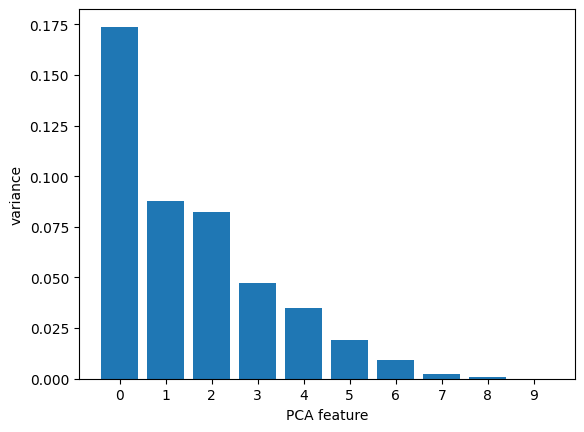

In [98]:
#Función para ejecutar modelo no supervisado

def func_scaler_pca(df):
    X_in = df.values
    #Escalar X
    #Escalado de todos los features Min_Max scaler
    # Import MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler
    # Instantiate MinMaxScaler
    MM_scaler = MinMaxScaler()
    # Fit MM_scaler to the data
    MM_scaler.fit(X_in)
    #Escalado de todos los features Min_Max scaler
    X = MM_scaler.transform(X_in)
    return X

def func_PCA(X_in):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    model=PCA()
    model.fit(X_in)
    X_transformed = model.transform(X_in)
    #print(X_transformed)
    #print(model.components_)
    features = range(model.n_components_)
    #print(features)
    plt.bar(features, model.explained_variance_)
    plt.xticks(features)
    plt.ylabel('variance')
    plt.xlabel('PCA feature')
    plt.show()
    return model, X_transformed

X = func_scaler_pca(df_migration_ml_pca)
pca, X_new = func_PCA(X)

<AxesSubplot:>

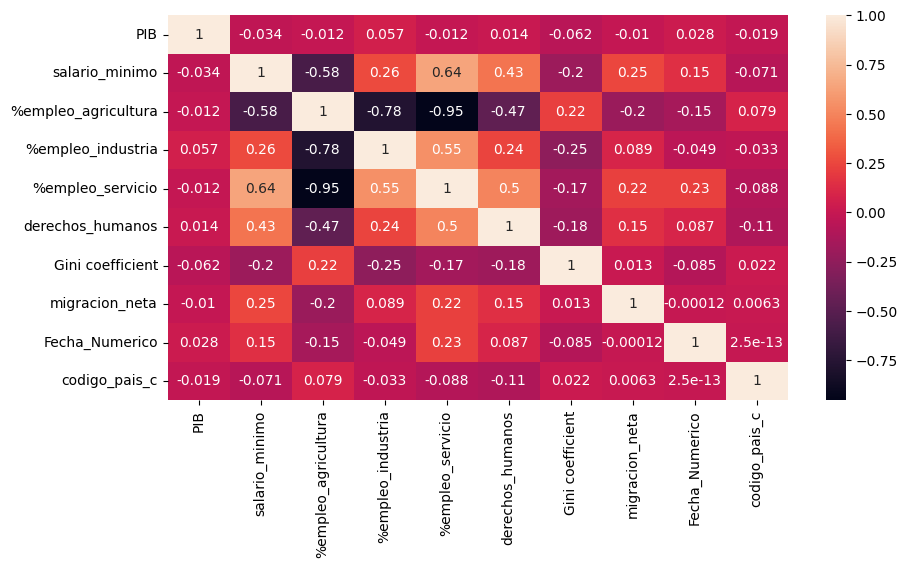

In [99]:
#Heat Map
corr = df_migration_ml_pca.corr()
plt.figure(figsize = (10,5))
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

In [100]:
columns_to_drop = ["Fecha_Numerico","codigo_pais_c"]
df_migration_ml_pca.drop(columns_to_drop,axis=1,inplace=True)

EJECUCION MODELO NO SUPERVISADO

In [101]:
#Funciones para ejecutar modelo no supervisado
def func_scaler_kmeans(df):
    #Escalado de todos los features Min_Max scaler
    X_in = df.drop(["codigo_pais"],axis=1).values
    # Import MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler
    # Instantiate MinMaxScaler
    MM_scaler = MinMaxScaler()
    # Fit MM_scaler to the data
    MM_scaler.fit(X_in)
    #Escalado de todos los features Min_Max scaler
    X = MM_scaler.transform(X_in)
    return X

def func_scaler_standard(df):
    X_in = df.drop(["codigo_pais"],axis=1).values
    #Escalar X
    #Escalado de todos los features Min_Max scaler
    # Import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    # Instantiate MinMaxScaler
    STD_scaler = StandardScaler()
    # Fit MM_scaler to the data
    STD_scaler.fit(X_in)
    #Escalado de todos los features Min_Max scaler
    X = STD_scaler.transform(X_in)
    return X

def func_clusters(X_in,number_of_clusters):
    from sklearn.cluster import KMeans
    kmeans=KMeans(n_clusters=number_of_clusters,random_state=32,init='k-means++')
    kmeans.fit(X_in)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    return labels, centroids

In [102]:
#Función para ejecutar elbow-method
def elbow_metodo(df,c_min,c_max):
    # Creamos una lista donde iremos guardando las distancias medias
    Sum_of_squared_distances = []
    X = func_scaler_kmeans(df)

    # Entrenamos un modelo para cada número de cluster que queremos testear
    K = np.arange(c_min,c_max)
    for k in K:
        # Definimos y entrenamos el modelo
        km = KMeans(n_clusters=k,random_state=32,init='k-means++')
        km = km.fit(X)
    
        # Calculamos la distancia media y agregamos a la lista
        distancia_total = km.inertia_
        distancia_media = np.divide(distancia_total,X.shape[0])
        Sum_of_squared_distances.append(distancia_media)

    plt.figure(figsize = (10,7))
    plt.plot(K, Sum_of_squared_distances, lw=3)
    plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
    plt.xlabel('Cantidad de clusters K')
    plt.ylabel('Inercia media')
    plt.title('Método del codo para el dataset 1')
    plt.show()
    return 

In [103]:
#Función para ejecutar Silhouette Score
def silhouette_metodo(df,c_min,c_max):
    from sklearn.metrics import silhouette_samples, silhouette_score
    #Método Silhouette
    # Creamos una lista donde iremos guardando los valores medios de silhouette
    lista_sil = []
    # Ingresamos el Dataset con el que queremos trabajar
    X = func_scaler_kmeans(df)
    K = np.arange(c_min,c_max)
    # Entrenamos un modelo para cada número de cluster que queremos testear
    for k in K:
        # Definimos y entrenamos el modelo
        km = KMeans(n_clusters=k,random_state=32,init='k-means++')
        km = km.fit(X)
    
        # Tomamos las etiquetas
        etiquetas = km.labels_
    
        # Calculamos el silhouette 
        valor_medio_sil = silhouette_score(X, etiquetas)
        lista_sil.append(valor_medio_sil)
    
    plt.figure(figsize = (10,7))
    plt.plot(K, lista_sil, lw=3)
    plt.scatter(K, lista_sil,s=55,c='r')
    plt.xlabel('Cantidad de clusters K')
    plt.ylabel('Silhouette media')
    plt.title('Silhouette media para el dataset 1', fontsize = 15)

    plt.show()
    return 

In [104]:
#Hierarchical clustering - Dendogram (Para ver el clustering jerarquico)
def hiercluster(X_in,df):
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import linkage, dendrogram
    samples = X_in
    mergings = linkage(samples, method='complete')
    country_name = df['codigo_pais'].to_list()
    dendrogram(mergings,
    labels = country_name,
    leaf_rotation=90,
    leaf_font_size=6)
    # plotting a line plot after changing it's width and height
    plt.rcParams["figure.figsize"] = [6.5, 15]
    plt.show()

In [105]:
def calculate_mean_df(df,start,stop):    
    start = convert_year_to_ordinal(start)
    stop = convert_year_to_ordinal(stop)
    df_range = df[(df.Fecha_Numerico>=start)&(df.Fecha_Numerico<=stop)]
    df_range = df_range.groupby('codigo_pais', as_index=False)["PIB","salario_minimo","%empleo_agricultura","%empleo_industria","%empleo_servicio","derechos_humanos","Gini coefficient","migracion_neta"].mean()
    return df_range

In [106]:
#Add labels to Dataframes
def add_labels(df,labels_in):
    df["labels"] =labels_in
    return df

#Function to show clusters
def func_groupby(df):
    df_group = df.groupby("labels").value_counts().reset_index(name='count')
    print(df.groupby("labels")["codigo_pais"].value_counts())
    df_group =df_group.drop("count",axis=1)
    return df_group

In [107]:
df_migration.head()

,pais_x,codigo_pais,anio,PIB,salario_minimo,%empleo_agricultura,%empleo_industria,%empleo_servicio,derechos_humanos,Gini coefficient,migracion_neta,Fecha_Numerico,codigo_pais_c
0,Afganistán,AFG,1991-01-01,0.927029,79.6,63.430000,12.43,24.139999,0.069,0.72,39926.0,726833,1
1,Afganistán,AFG,1992-01-01,0.927029,79.6,63.650002,12.21,24.139999,0.071,0.72,1834556.0,727198,1
2,Afganistán,AFG,1993-01-01,0.927029,79.6,64.410004,11.57,24.030001,0.077,0.72,1171818.0,727564,1
3,Afganistán,AFG,1994-01-01,0.927029,79.6,64.440002,11.48,24.080000,0.078,0.72,665410.0,727929,1
4,Afganistán,AFG,1995-01-01,0.927029,79.6,64.300003,11.51,24.190001,0.075,0.72,71824.0,728294,1


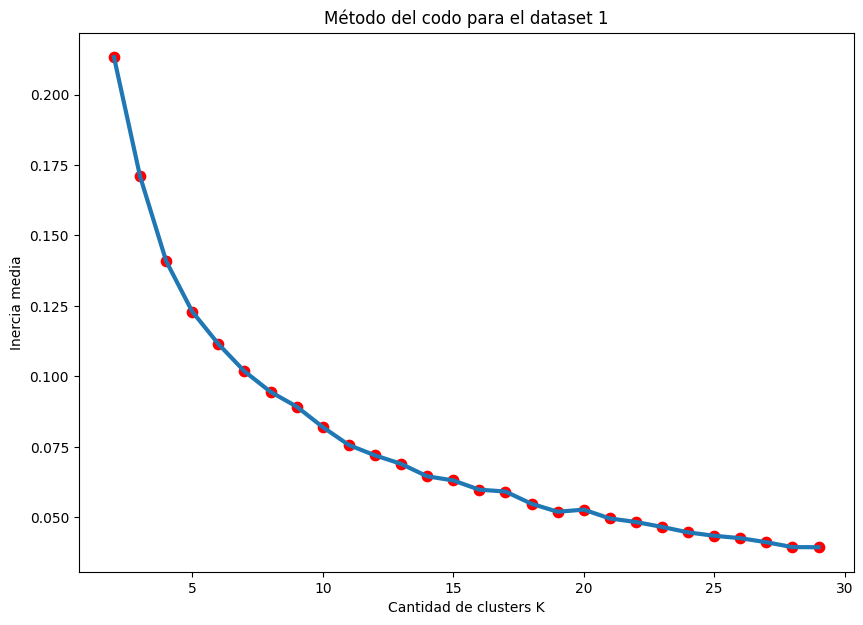

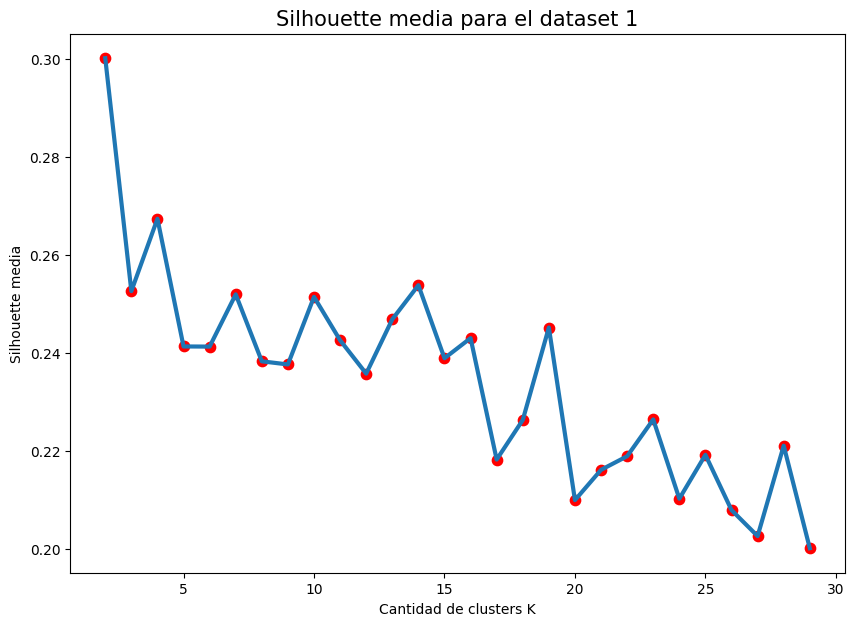

labels  codigo_pais
0       ALB            1
        ARM            1
        BEN            1
        BFA            1
        BOL            1
                      ..
9       LBN            1
        MDV            1
        MYS            1
        RUS            1
        UKR            1
Name: codigo_pais, Length: 158, dtype: int64
{'AFG': 6, 'AGO': 8, 'ALB': 0, 'ARE': 9, 'ARG': 5, 'ARM': 0, 'AUS': 4, 'AUT': 1, 'AZE': 3, 'BDI': 2, 'BEL': 4, 'BEN': 0, 'BFA': 0, 'BGD': 7, 'BGR': 1, 'BIH': 1, 'BLR': 9, 'BLZ': 5, 'BOL': 0, 'BRA': 5, 'BTN': 8, 'BWA': 5, 'CAF': 2, 'CAN': 4, 'CHE': 4, 'CHL': 5, 'CHN': 7, 'CIV': 0, 'CMR': 0, 'COD': 2, 'COG': 3, 'COL': 5, 'COM': 0, 'CPV': 5, 'CRI': 5, 'CYP': 4, 'CZE': 1, 'DEU': 4, 'DNK': 4, 'DOM': 5, 'DZA': 9, 'ECU': 0, 'EGY': 7, 'ESP': 4, 'EST': 1, 'ETH': 2, 'FIN': 4, 'FJI': 9, 'FRA': 4, 'GAB': 0, 'GBR': 4, 'GEO': 0, 'GHA': 0, 'GIN': 8, 'GMB': 0, 'GNB': 8, 'GNQ': 3, 'GRC': 4, 'GTM': 0, 'GUY': 5, 'HKG': 4, 'HND': 0, 'HRV': 1, 'HTI': 0, 'HUN': 1, 'IDN': 0,

In [108]:
#Calculo promedio últimos 5 años
df_migration = df_migration
dfm_ml_kmeans = calculate_mean_df(df_migration,start ="2014",stop="2019")

#Ejecución del código y funciones de modelo no supervisado para el dataframe dfm_ml
elbow_metodo(dfm_ml_kmeans,2,30)
silhouette_metodo (dfm_ml_kmeans,2,30)
X = func_scaler_kmeans(dfm_ml_kmeans)
labels, centroids = func_clusters(X,10)
dfm_ml = add_labels(dfm_ml_kmeans,labels)
df_group = func_groupby(dfm_ml)
#se crea diccionario para luego añadir al Dtaframe de la regresión lineal
dict_cluster_country = dict(zip(dfm_ml["codigo_pais"], dfm_ml["labels"]))
print(dict_cluster_country)

EJECUCION MODELO SUPERVISADO

In [109]:
#Función para ejecutar escalado modelo no supervisado
def func_scaler_linear(df):
    #Escalar X
    X_in = df.drop(["pais_x","codigo_pais","migracion_neta","anio","labels"],axis=1).values
    #Escalado de todos los features Min_Max scaler
    # Import MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler
    # Instantiate MinMaxScaler
    MM_scaler = MinMaxScaler()
    # Fit MM_scaler to the data
    MM_scaler.fit(X_in)
    #Escalado de todos los features Min_Max scaler
    X = MM_scaler.transform(X_in)
    return MM_scaler

def regresion_lineal (df,MM_scaler_in):
    # Importamos el módulo que contiene el algorimto de regresión lineal
    from sklearn.linear_model import LinearRegression 
    # Importar MinMaxScaler para escalar los features
    from sklearn.preprocessing import MinMaxScaler
    #Importar Biblioteca para graficar 
    import matplotlib.pyplot as plt 
    #Importar función para calcular el Mean squared error
    from sklearn.metrics import mean_squared_error

    #Separar para hacer escaldo
    X_in = df.drop(["pais_x","codigo_pais","migracion_neta","anio","labels"],axis=1).values
    y = df["migracion_neta"].values

    #Se separan en train y test set
    X_train = df[(df.Fecha_Numerico>=730120)&(df.Fecha_Numerico<733733)]
    X_train = X_train.drop(["pais_x","codigo_pais","migracion_neta","anio","labels"],axis=1).values 
    y_train = df[(df.Fecha_Numerico>=730120)&(df.Fecha_Numerico<733733)]["migracion_neta"].values

    X_test = df[(df.Fecha_Numerico>=733733)&(df.Fecha_Numerico<= 737425)]
    X_test = X_test.drop(["pais_x","codigo_pais","migracion_neta","anio","labels"],axis=1).values
    y_test = df[(df.Fecha_Numerico>=733733)&(df.Fecha_Numerico<=737425)]["migracion_neta"].values

    MM_scaler = MM_scaler_in

    #Escalado de todos los features Min_Max scaler
    X_train= MM_scaler.transform(X_train)
    X_test = MM_scaler.transform(X_test)

    # Instanciamos un objeto de la clase LinearRegression. Aquí estamos creando nuestro modelo predictivo 'linear_model'
    linear_model = LinearRegression() 

    # Entrenamos el modelo
    linear_model.fit(X_train, y_train)

    #Hacemos las predicciones
    y_train_pred = linear_model.predict(X_train)
    y_test_pred = linear_model.predict(X_test)

    # Print R^2 
    print('El coeficiente de determinación es:', linear_model.score(X_train, y_train))
    print('Error en datos de train:', mean_squared_error(y_train_pred, y_train))
    print('Error en datos de test:', mean_squared_error(y_test, y_test_pred))
    return linear_model


In [110]:
#Función predicción
def func_prediction(country_in,year_in,model_in,MM_scaler_in,diccionario):
    MM_scaler = MM_scaler_in
    df_input = pd.DataFrame([diccionario])
    X_new = MM_scaler.transform(df_input.values)
    model = model_in
    prediction  = model.predict(X_new)
    print('La cantidad que se predice para migración es :' + str(round(prediction[0],2)))
    return 

In [111]:
year = convert_year_to_ordinal("2010")
df_migration[(df_migration["codigo_pais"] == 'USA') & (df_migration["Fecha_Numerico"] == year)]

,pais_x,codigo_pais,anio,PIB,salario_minimo,%empleo_agricultura,%empleo_industria,%empleo_servicio,derechos_humanos,Gini coefficient,migracion_neta,Fecha_Numerico,codigo_pais_c
4340,Estados Unidos,USA,2010-01-01,1.860292,1256.67,1.42,19.639999,78.940002,0.951,0.400107,1030731.0,733773,150


In [115]:
df_migration = df_migration
df_migration["labels"] = df_migration["codigo_pais"].map(dict_cluster_country)

#Ejecutar función escaldo-Ejecutar Función regresión
MM_scaler_func = func_scaler_linear(df_migration)
model = regresion_lineal(df_migration,MM_scaler_func)

#Generando predicción - datos de Entrada
country='USA'
year="2010"
PIB = 1.860292
salario_minimo = 1256.67
empleo_agricultura = 1.42
empleo_industria = 19.64
empleo_servicio = 78.94
derechos_humanos = 0.951
gini_coefficient = 0.400107
codigo_pais_c = 150
year_num = convert_year_to_ordinal(year)

diccionario_input = {"PIB":PIB,
                    "salario_minimo":salario_minimo,
                    "empleo_agricultura": empleo_agricultura,
                    "empleo_industria": empleo_industria,
                    "empleo_servicio":empleo_servicio,
                    "derechos_humanos":derechos_humanos,
                    "Gini_coefficient": gini_coefficient,
                    "Fecha_Numerico": year_num, 
                    "codigo_pais_c":codigo_pais_c,
                    }

df_input = pd.DataFrame([diccionario_input])
X_new_scaled = MM_scaler_func.transform(df_input.values)
func_prediction(country_in=country,year_in=year,model_in=model,MM_scaler_in=MM_scaler_func,diccionario=diccionario_input)

El coeficiente de determinación es: 0.11140983772827329
Error en datos de train: 31486932600.6224
Error en datos de test: 45770713033.21419
La cantidad que se predice para migración es :125748.22


In [116]:
df_migration = df_migration
df_migration["labels"] = df_migration["codigo_pais"].map(dict_cluster_country)

#funcion para filtrar el label de un pais-input
def label_pais(country_code,df):
    indice = df[df["codigo_pais"] == country_code].index
    label_country = df.loc[indice[0], "labels"]
    return label_country 

def regresion_group(df,lista_new):
    list_test = []
    list_MMscaler = []
    list_linfunc = []
    list_df = []
    df_1 = df
    group = lista_new
    for i in range (0,len(group)):
        list_test.append(group[i].tolist())
        list_df.append(country_reduce(df_1,list_test[i]))
        list_MMscaler.append(func_scaler_linear(list_df[i]))
        list_linfunc.append(regresion_lineal(list_df[i],list_MMscaler[i]))
    return list_MMscaler, list_linfunc 

#Generando predicción - datos de Entrada
country='USA'
year="2010"
PIB = 1.860292
salario_minimo = 1256.67
empleo_agricultura = 1.42
empleo_industria = 19.64
empleo_servicio = 78.94
derechos_humanos = 0.951
gini_coefficient = 0.400107
codigo_pais_c = 150
year_num = convert_year_to_ordinal(year)

diccionario_input = {"PIB":PIB,
                    "salario_minimo":salario_minimo,
                    "empleo_agricultura": empleo_agricultura,
                    "empleo_industria": empleo_industria,
                    "empleo_servicio":empleo_servicio,
                    "derechos_humanos":derechos_humanos,
                    "Gini_coefficient": gini_coefficient,
                    "Fecha_Numerico": year_num, 
                    "codigo_pais_c":codigo_pais_c,
                    }

#Guardar ,,label'' país en una nueva variable
indice = label_pais(country,df_migration)

#se agrupan por grupos de paises (clusters) segun label
country_group = df_migration.groupby("labels")["codigo_pais"].unique().tolist()


#Llamando a la funcción para predecir
list_MMscaler, list_linfunc = regresion_group(df_migration,country_group)
func_prediction(country_in=country,year_in=year,model_in=list_linfunc[indice],MM_scaler_in=list_MMscaler[indice],diccionario=diccionario_input)

El coeficiente de determinación es: 0.10614065695011632
Error en datos de train: 2784844982.1038413
Error en datos de test: 2736496511.3161163
El coeficiente de determinación es: 0.3439833772798121
Error en datos de train: 4678716513.541809
Error en datos de test: 2312221729.0828624
El coeficiente de determinación es: 0.6510201414746553
Error en datos de train: 1498356774.862887
Error en datos de test: 8109172405.59593
El coeficiente de determinación es: 0.2431263708071444
Error en datos de train: 18226877600.543564
Error en datos de test: 152243733632.9652
El coeficiente de determinación es: 0.1895609421987755
Error en datos de train: 50591235166.60652
Error en datos de test: 53406557591.53474
El coeficiente de determinación es: 0.33047928953026784
Error en datos de train: 3289910174.5608544
Error en datos de test: 12244522194.532068
El coeficiente de determinación es: 0.20582898219480628
Error en datos de train: 68616653201.81553
Error en datos de test: 284862116598.9627
El coeficien